# Wildland Data Acquisition

The goal of this notebook is to help with the overall wildland fire analysis for Indianapolis, Indiana, by loading the WildLand Fire data as a geopandas GeoDataFrame, filtering the wildfire observations to those that occurred in the last 60 years, and are within 650 miles of Indianapolis.

This notebook also performs the smoke estimation, which will be later compared to available AQI data, in the main analysis notebook. 

In [1]:
#########
#
#    IMPORTS
#

# In-built libraries
import os
import json

# Third-party libraries
import numpy as np
import pandas as pd
import geopandas as gpd

# Other third-party libraries
import copy
import fiona
from shapely.geometry import Polygon, Point
import contextily as cx
import folium.folium
import matplotlib.pyplot as plt
from geopandas.explore import _categorical_legend
from folium.plugins import Geocoder
from matplotlib.colors import rgb2hex

# Local libraries
from utils import plot_gdf, explore_gdf

In [2]:
#########
#
#    CONSTANTS
#
DATA_PATH = "data/Fire_Feature/Fire_Feature_Data.gdb"

## Load the USGS Wildland Fire Combined Dataset

The US wildfires data was collected and processed by the US Geological Survey in the following page: [Combined wildland fire datasets for the United States and certain territories, 1800s-Present (combined wildland fire polygons)](https://www.sciencebase.gov/catalog/item/61aa537dd34eb622f699df81)

For this analysis, we will be using the Geodatabase file stored as `Fire_Feature_Data_Pro2_8_Geodatabase.zip`. This folder includes the following: 
- A raw merged dataset containing duplicates 
- A post-processed, duplicate-free, dataset that comprises both wildfires and prescribed fires from mid 1800s to the 2021 compiled from 40 different original wildfire datasets.

The data was extracted using `geopandas`, `fiona` and `shapely`. \
Note: While the initial attempt was to utilize the `GeoJSON files.zip` file, since GeoJSON is more easy to work with, when using `geopandas`, it turns out that this file is not appropriate for direct usage, because it still, to a large extent, follows the ESRI format, which is more suitable for ArcGIS. Thus, `geopandas` fails to process some of the rows properly and errors out while trying to load the entire geojson file.\
The Geodatabase file proved less challenging to work with, since, as it turns out, `geopandas` can indeed work with Geodatabase files of ESRI format.

In [4]:
# Use fiona package to list layers present in the geodatabase
# The combined layer will be loaded into a GeoDataFrame using geopandas
layers: list = fiona.listlayers(DATA_PATH)
print("Available layers:", layers)

Available layers: ['USGS_Wildland_Fire_Combined_Dataset', 'USGS_Wildland_Fires_Overlapping_Fire_Data', 'USGS_Wildland_Fire_Merged_Dataset']


In [6]:
COMBINED_DATASET_LAYER = "USGS_Wildland_Fire_Combined_Dataset"

In [6]:
fire_feature_gdf: gpd.GeoDataFrame = gpd.read_file(DATA_PATH, layer=COMBINED_DATASET_LAYER)

/home/hnaidu36/miniforge3/envs/data512/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  return ogr_read(


In [7]:
fire_feature_gdf.head(1)

,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,Listed_Fire_Names,...,Wildfire_Notice,Prescribed_Burn_Notice,Wildfire_and_Rx_Flag,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,geometry
0,1,Wildfire,1860,1,1 (1),3940.207089,1594.545237,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (1),Big Quilcene River (1),...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,None,None,0.04759,NaN,No,64888.449849,1.594545e+07,"MULTIPOLYGON (((-1883775.596 1194154.192, -188..."


In [8]:
print(f"The dataframe contains {fire_feature_gdf.shape[0]} observations and {fire_feature_gdf.shape[1]} attributes.")
print(f"The CRS of the GeoDataFrame is: {fire_feature_gdf.crs}")

The dataframe contains 135061 observations and 30 attributes.
The CRS of the GeoDataFrame is: PROJCS["North_America_Albers_Equal_Area_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",20],PARAMETER["standard_parallel_2",60],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","102008"]]


In [ ]:
fire_feature_gdf.columns

Index(['USGS_Assigned_ID', 'Assigned_Fire_Type', 'Fire_Year',
       'Fire_Polygon_Tier', 'Fire_Attribute_Tiers', 'GIS_Acres',
       'GIS_Hectares', 'Source_Datasets', 'Listed_Fire_Types',
       'Listed_Fire_Names', 'Listed_Fire_Codes', 'Listed_Fire_IDs',
       'Listed_Fire_IRWIN_IDs', 'Listed_Fire_Dates', 'Listed_Fire_Causes',
       'Listed_Fire_Cause_Class', 'Listed_Rx_Reported_Acres',
       'Listed_Map_Digitize_Methods', 'Listed_Notes', 'Processing_Notes',
       'Wildfire_Notice', 'Prescribed_Burn_Notice', 'Wildfire_and_Rx_Flag',
       'Overlap_Within_1_or_2_Flag', 'Circleness_Scale', 'Circle_Flag',
       'Exclude_From_Summary_Rasters', 'Shape_Length', 'Shape_Area',
       'geometry'],
      dtype='object')

## Filter Data to observations relevant to Indianapolis, IN

In this analysis, we will only focus in a select subset of Wildland fires that satisfy the following conditions:
- Occurred in the last 60 years: [1964 - Present]
- Within 650 miles of Indianapolis, IN 

In [3]:
#########
#
#    Additional Constants
#
DISTANCE_EPSG = 5070
WORLD_EPSG = 4326

METERS_TO_MILES = 0.00062137

DISTANCE_THRESHOLD_MILES = 650

INDIANAPOLIS_COORDINATES = (39.7684, -86.1580)
INDIANAPOLIS_POINT: Point = Point(INDIANAPOLIS_COORDINATES[1], INDIANAPOLIS_COORDINATES[0])  # (longitude, latitude)

### Date Filtering

In [11]:
# Get Wildland fires that occurred only in the last 60 years: [1964 - Present]
fire_feature_valid_dates_gdf: gpd.GeoDataFrame = fire_feature_gdf[fire_feature_gdf['Fire_Year'] >= 1964]

# Note: final_fire_feature_gdf will be the final dataset used for analysis, after all the filtering and processing

### CRS Conversion Set up

After further analysis on GIS, it turns out that `EPSG:4326` may not be ideal for distance calculation as it does not take into account the curvature of the Earth. 

Instead, we will go with `EPSG:5070` (Conus Albers / USA Contiguous Albers Equal Area Conic). This CRS is indeed well-suited for the contiguous United States and designed specifically to minimize distortion for both area and distance across this region. It should provide accurate distance calculations across the entire country, making it ideal for our needs.

However, `EPSG:4326` will nonetheless be useful for visualization purposes, since it works seamlessly with `geopandas.explore()`

Also, the conversion from `ESRI:102008` to `EPSG:4326` is the only valid ESRI-EPSG transformation in this context, hence `EPSG:4326` will be the first transformation made

To continue processing of the dataframes, it would be prudent to convert the geometry from the ESRI:102008 coordinate system to EPSG:4326 coordinates.

Note: The following code was executed on a system equipped with a 12th Gen Intel® Core™ i7-12700H processor (2.30 GHz). The total execution time for this loop was around 1 minute.

In [12]:
# Convert the geometry from ESRI:102008 to ESRI:102005
fire_feature_valid_dates_gdf: gpd.GeoDataFrame = fire_feature_valid_dates_gdf.to_crs(epsg=WORLD_EPSG)

# Convert the geometry of Indianapolis point to GeoSeries with ESRI:102005
Indianapolis_projected_point = gpd.GeoSeries([INDIANAPOLIS_POINT], crs=f"EPSG:{WORLD_EPSG}")

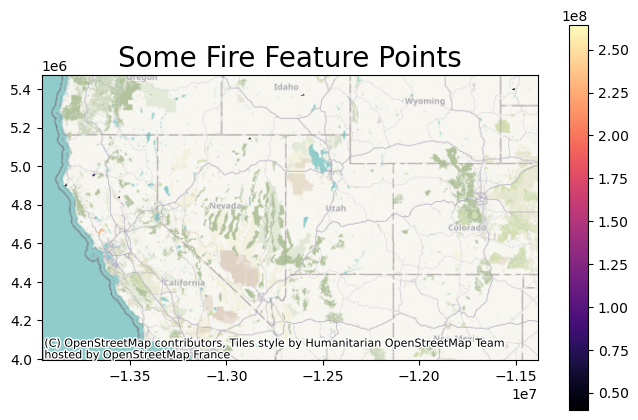

In [13]:
# As mentioned, EPSG:4326 can be used for mapping, but for distance calculations, we will use EPSG:5070
fix, ax = plot_gdf(fire_feature_valid_dates_gdf[:10], 'Shape_Area', cmap='magma', title='Some Fire Feature Points', 
    figsize=(8, 5))
plt.show()

### Distance Filtering

In [4]:
#########
#
#    Additional Constants
DISTANCE_COL = 'Distance'

In [15]:
fire_feature_valid_dates_gdf[DISTANCE_COL] = \
fire_feature_valid_dates_gdf.to_crs(epsg=DISTANCE_EPSG)\
    .distance(Indianapolis_projected_point.to_crs(epsg=DISTANCE_EPSG)[0]) * METERS_TO_MILES

In [16]:
# Filter rows that have Distance less than the threshold
fire_feature_valid_gdf = fire_feature_valid_dates_gdf[fire_feature_valid_dates_gdf[DISTANCE_COL] <= DISTANCE_THRESHOLD_MILES]

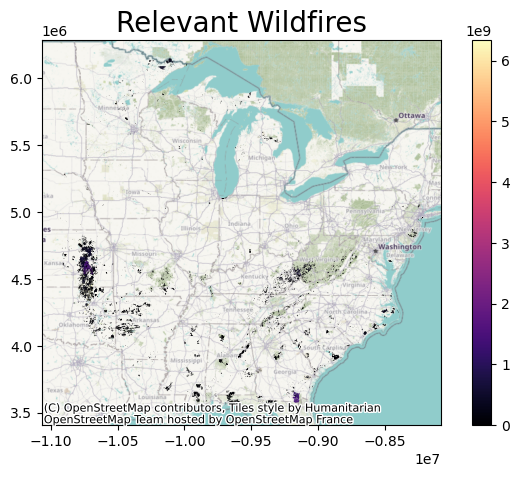

In [13]:
# As mentioned, EPSG:4326 can be used for mapping, but for distance calculations, we will use EPSG:5070
fix, ax = plot_gdf(fire_feature_valid_gdf, 'Shape_Area', cmap='magma', title='Relevant Wildfires', 
    figsize=(8, 5))
plt.show()

### Save the Filtered File

In [5]:
SAVE_PATH = 'intermediate/filtered_fire_features.geojson'

In [25]:
# Save the filtered GeoDataFrame to a new file
fire_feature_valid_gdf.to_file(SAVE_PATH, driver='GeoJSON')

In [6]:
# In the future, we can load the filtered GeoDataFrame using:
# fire_feature_valid_gdf = gpd.read_file(SAVE_PATH)

In [20]:
# Get only the relevant columns
# for col in fire_feature_valid_gdf.columns:
#     print(f"\"{col}\",")

RELEVANT_COLUMNS = [
    "USGS_Assigned_ID",
    "Assigned_Fire_Type",
    "Fire_Year",
    # "Fire_Polygon_Tier",
    # "Fire_Attribute_Tiers",
    # "GIS_Acres",
    # "GIS_Hectares",
    # "Source_Datasets",
    # "Listed_Fire_Types",
    # "Listed_Fire_Names",
    # "Listed_Fire_Codes",
    # "Listed_Fire_IDs",
    # "Listed_Fire_IRWIN_IDs",
    "Listed_Fire_Dates",
    # "Listed_Fire_Causes",
    # "Listed_Fire_Cause_Class",
    # "Listed_Rx_Reported_Acres",
    # "Listed_Map_Digitize_Methods",
    # "Listed_Notes",
    # "Processing_Notes",
    # "Wildfire_Notice",
    # "Prescribed_Burn_Notice",
    # "Wildfire_and_Rx_Flag",
    # "Overlap_Within_1_or_2_Flag",
    # "Circleness_Scale",
    # "Circle_Flag",
    # "Exclude_From_Summary_Rasters",
    "Shape_Length",
    "Shape_Area",
    "Distance",
    "geometry"
]

In [21]:
fire_feature_valid_subset_gdf = fire_feature_valid_gdf[RELEVANT_COLUMNS]

In [26]:
for c in list(fire_feature_valid_subset_gdf['Assigned_Fire_Type'].unique()):
    print(f"\"{c}\": ,")

"Wildfire": ,
"Unknown - Likely Wildfire": ,
"Likely Wildfire": ,
"Prescribed Fire": ,
"Unknown - Likely Prescribed Fire": ,


## Create Smoke Estimates

Our aim is to provide an annual estimate of wildfire smoke levels in Indianapolis, Indiana, to better understand how wildfires affect city residents.

Smoke levels are typically influenced by several factors such as wind patterns over days, fire intensity, duration, proximity to the city, etc. For this analysis, however, we’re working with just the fire area and distance data. 

We can also use the fire type—distinguishing between prescribed burns and true wildfires—as a stand-in for fire intensity.
Prescribed burns, usually planned for optimal weather conditions, are intended to reduce both safety risks and smoke spread, meaning they likely contribute less to smoke exposure in nearby cities compared to wildfires.

### Create a Model for the Smoke Estimates

Taking inspiration from the "inverse-square law," which is common for concepts like light, sound, and gravity, we can postulate the relationship between smoke, distance and area to be the following:
$$\text{Smoke} \propto \frac{\text{Area}}{\text{Distance}^2}$$

As mentioned before, we hypothesize that true wildfires have a greater impace on smoke. We will be encoding fire-type as a quantitative variable, where the value of impact is lower if the fire is controlled.\
We will postulate the relationship between smoke and fire-type to be the following:
$$\text{Smoke} \propto Fire\_Type$$  
(where $Fire\_Type_{true} > Fire\_Type_{prescribed}$)

We would also take into consideration some interaction between distance, area and fire-type. 

Taking all these relationships into account, we can have the following formula (based on the linear regression formula):
$$\text{Smoke} = \beta_0 + \beta_1 \frac{\text{Area}}{\text{Distance}^2} + \beta_2 Fire\_Type + \beta_3 \frac{\text{Area}}{\text{Distance}^2} Fire\_Type$$

In [50]:
# Constants
AREA_COL = 'Shape_Area'
DISTANCE_COL = 'Distance'
FIRE_TYPE_COL = 'Assigned_Fire_Type'

SMOKE_ESTIMATE_COL = 'smoke_estimate'

## Fire type map
FIRE_TYPE_MAP = {
    "Wildfire": 5,
    "Likely Wildfire": 4,
    "Unknown - Likely Wildfire": 3,
    "Unknown - Likely Prescribed Fire": 2,
    "Prescribed Fire": 1,
}

## Betas
BETA_0 = 0
BETA_1 = 0
BETA_2 = 0
BETA_3 = 1

We will thus be using the following attributes of the GeoDataFrame as our independent variables:
- Area: `Shape_Area`
- Distance: `Distance`
- Fire_Type: `Assigned_Fire_Type` encoded as (effectively) a quantitative variable dependending on the fire type:
    * 'Wildfire': 5
    * 'Likely Wildfire': 4
    * 'Unknown - Likely Wildfire': 3
    * 'Unknown - Likely Prescribed Fire': 2 
    * 'Prescribed Fire': 1

For the given model, we will be giving the betas the following values (thus, accounting only for interaction among all the variables):
- $\beta_0$ = 0
- $\beta_1$ = 0
- $\beta_2$ = 0
- $\beta_3$ = 1

In [37]:
def calc_smoke_estimate(fire_feature_row):
    """
    Calculate smoke estimate based on fire feature attributes.

    Parameters:
    ----------
    fire_feature_row (pd.Series): A row from the fire feature GeoDataFrame.
    
    Returns:
    ----------
    float: Estimated smoke amount.
    """
    a = fire_feature_row[AREA_COL]
    d = fire_feature_row[DISTANCE_COL]
    t = FIRE_TYPE_MAP[fire_feature_row[FIRE_TYPE_COL]]

    smoke_estimate = BETA_0 + BETA_1 * (a/(d*d)) + BETA_2 * t + BETA_3 * (a*t/(d*d))
    return smoke_estimate

In [43]:
# Calculate smoke estimates for each fire feature
fire_feature_valid_subset_gdf[SMOKE_ESTIMATE_COL] = fire_feature_valid_subset_gdf.apply(calc_smoke_estimate, axis=1)

/home/hnaidu36/miniforge3/envs/data512/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### Exploratory Data Analysis on the Calculated Smoke Estimates

Axes(0.125,0.11;0.775x0.77)


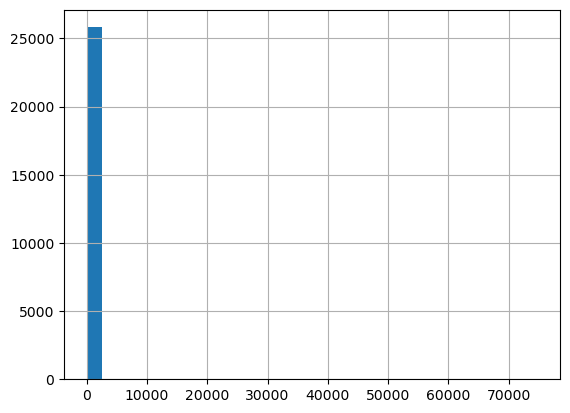

In [46]:
fire_feature_valid_subset_gdf['smoke_estimate'].hist(bins=30)

In [49]:
fire_feature_valid_subset_gdf[SMOKE_ESTIMATE_COL].describe()

count    2.591100e+04
mean     6.756802e+01
std      7.105333e+02
min      2.745319e-09
25%      4.359551e-01
50%      3.651788e+00
75%      2.704405e+01
max      7.476780e+04
Name: smoke_estimate, dtype: float64

In [53]:
other_bins = [500]
fire_feature_valid_subset_gdf[SMOKE_ESTIMATE_COL].sort_values().value_counts(bins=[0, *other_bins, float('inf')], sort=False)

(-0.001, 500.0]    25403
(500.0, inf]         508
Name: count, dtype: int64

In [52]:
bins = [10, 25, 100, 500, 1000, 5000, 10000, 50000]
fire_feature_valid_subset_gdf[SMOKE_ESTIMATE_COL].sort_values().value_counts(bins=[0, *bins, float('inf')], sort=False)

(-0.001, 10.0]        16003
(10.0, 25.0]           3132
(25.0, 100.0]          4286
(100.0, 500.0]         1982
(500.0, 1000.0]         246
(1000.0, 5000.0]        228
(5000.0, 10000.0]        22
(10000.0, 50000.0]       10
(50000.0, inf]            2
Name: count, dtype: int64

In [54]:
fire_feature_valid_subset_gdf[SMOKE_ESTIMATE_COL].sort_values().value_counts(bins=[0, 500, float('inf')], sort=False)

(-0.001, 500.0]    25403
(500.0, inf]         508
Name: count, dtype: int64

While some outliers exist in these smoke estimates that exceed the maximum value of AQI (500), these form only about 2% of the data, so these can be accommodated.

In [58]:
# Check the largest smoke estimates
fire_feature_valid_subset_gdf.sort_values(by=SMOKE_ESTIMATE_COL, ascending=False)\
    .drop(['geometry', 'Listed_Fire_Dates', 'Shape_Length'], axis=1).head(5)

,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Shape_Area,Distance,smoke_estimate
8709,77681,Wildfire,1987,7.950665e+08,230.584150,74767.796865
15317,102012,Unknown - Likely Prescribed Fire,2009,6.338483e+09,492.353420,52295.146859
9674,81023,Wildfire,2007,4.462495e+06,30.450430,24063.614327
8930,78467,Wildfire,1991,2.991128e+08,268.270664,20780.628278
8724,77696,Unknown - Likely Wildfire,1987,2.676801e+08,202.175704,19646.235021


As one can see, these outliers are extremely massive wildfires, that are relatively close to Indianapolis.

In [59]:
# Check the smallest smoke estimates
fire_feature_valid_subset_gdf.sort_values(by=SMOKE_ESTIMATE_COL, ascending=True)\
    .drop(['geometry', 'Listed_Fire_Dates', 'Shape_Length'], axis=1).head(5)

,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Shape_Area,Distance,smoke_estimate
6939,63533,Wildfire,2013,0.000092,409.516337,2.745319e-09
11843,89277,Wildfire,2000,0.002654,420.806816,7.494563e-08
10956,87866,Likely Wildfire,1990,0.006912,462.036879,1.295159e-07
11432,88595,Likely Wildfire,1996,0.006977,432.298780,1.493335e-07
13940,97406,Wildfire,2020,0.013112,593.733424,1.859723e-07


As one can see, these lowest values are extremely small and mostly distant wildfires.

### Calculate Annual Smoke Estimates